# convert class labels to wordnet synset identifiers

(this is required to use CoOp on ImageNet without modifying CoOp)

TODO: move this into some ../utils/ script once you get it working

## load validation labels

In [32]:
val_img_labels = dict()
# with open('../data/imagenet/devkit-1.0/data/ILSVRC2010_validation_ground_truth.txt') as f:
with open('../data/imagenet/ILSVRC2012_devkit_t12/data/ILSVRC2012_validation_ground_truth.txt') as f:
    for i, label in enumerate(f):
        val_img_labels[i+1] = int(label.strip()) - 1

In [33]:
assert len(val_img_labels) == 50000

## get label to synset dict

In [12]:
import scipy.io

In [34]:
# mat = scipy.io.loadmat('../data/imagenet/devkit-1.0/data/meta.mat')
mat = scipy.io.loadmat('../data/imagenet/ILSVRC2012_devkit_t12/data/meta.mat')
synset_id_to_int_label = {m[0][1][0]: m[0][0][0][0]-1 for m in mat['synsets']}
synset_id_to_class_name = {m[0][1][0]: m[0][2][0] for m in mat['synsets']}

int_label_to_synset = dict()
for synset_id in synset_id_to_int_label.keys():
    label = synset_id_to_int_label[synset_id]
    name = synset_id_to_class_name[synset_id]
    int_label_to_synset[label] = {'synset_id': synset_id, 'name': name}

## test it

In [35]:
import random
from IPython.display import display, Image, HTML, Markdown

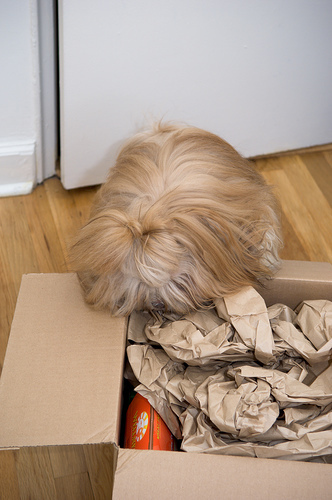

Image 12931: Lhasa, Lhasa apso (synset ID: `n02098413`)

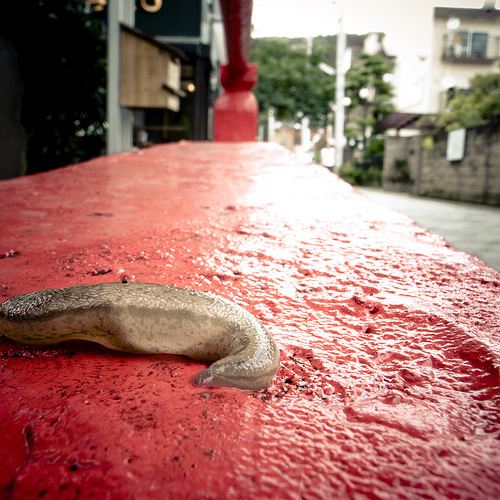

Image 14762: slug (synset ID: `n01945685`)

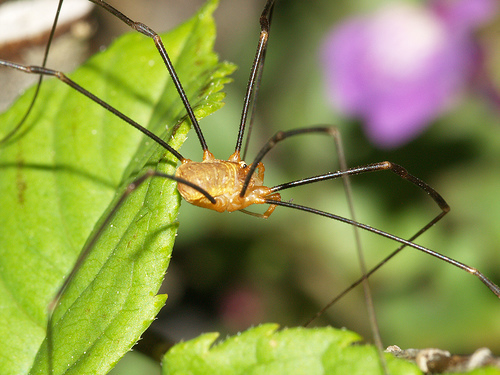

Image 35512: harvestman, daddy longlegs, Phalangium opilio (synset ID: `n01770081`)

In [36]:
for _ in range(3):
    img_idx = random.randint(1, 50001)
#     img_path = f'../data/imagenet/images/val/ILSVRC2010_val_{img_idx:08d}.JPEG'
    img_path = f'../data/imagenet/images/val/ILSVRC2012_val_{img_idx:08d}.JPEG'
    img_label = val_img_labels[img_idx]
    synset = int_label_to_synset[img_label]
    synset_id = synset['synset_id']
    name = synset['name']

    display(Image(img_path))
    display(Markdown(f"Image {img_idx}: {name} (synset ID: `{synset_id}`)"))

# create train image folder from validation images

yes, this is not how we want to be doing things long-term, but while we wait for the train set to download (and want to compare directly to ImageNet-C, which is also the validation set), this is easier

In [41]:
import os
import sys
import pickle
import shutil
from tqdm import tqdm

In [42]:
for img_idx in tqdm(range(1, 50001)):
#     img_path = f'../data/imagenet/images/val/ILSVRC2010_val_{img_idx:08d}.JPEG'
    img_path = f'../data/imagenet/images/val/ILSVRC2012_val_{img_idx:08d}.JPEG'
    img_label = val_img_labels[img_idx]
    synset = int_label_to_synset[img_label]
    synset_id = synset['synset_id']
    name = synset['name']

    synset_id_dir = f'../data/imagenet/images/train/{synset_id}'
    if not os.path.exists(synset_id_dir):
        os.mkdir(synset_id_dir)
        with open(f'{synset_id_dir}/._SYNSET_.pickle', 'wb') as f:
            pickle.dump(synset, f)
    shutil.copy(img_path, synset_id_dir)

100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [03:46<00:00, 221.09it/s]


## confirm that this worked as intended

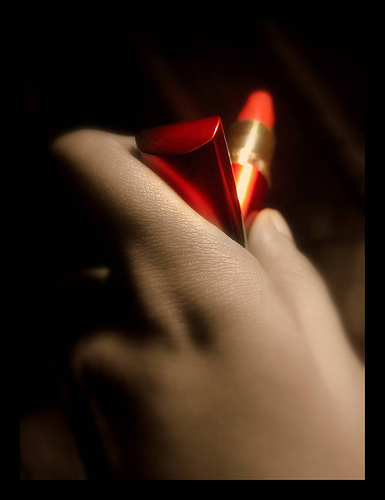

Image ILSVRC2012_val_00037921.JPEG: lipstick, lip rouge (synset ID: `n03676483`)

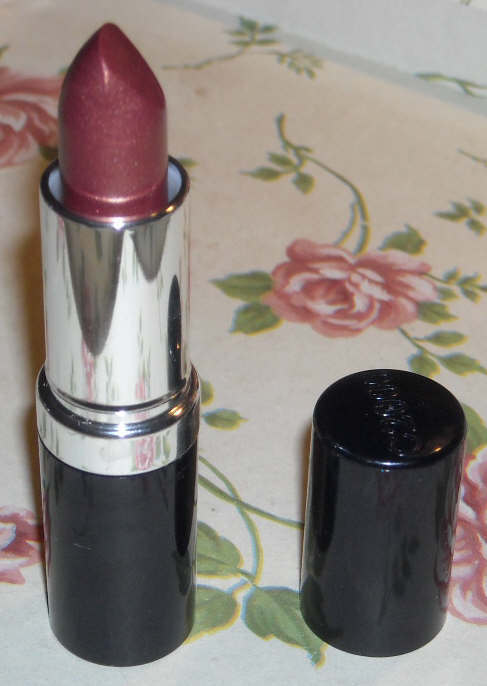

Image ILSVRC2012_val_00048483.JPEG: lipstick, lip rouge (synset ID: `n03676483`)

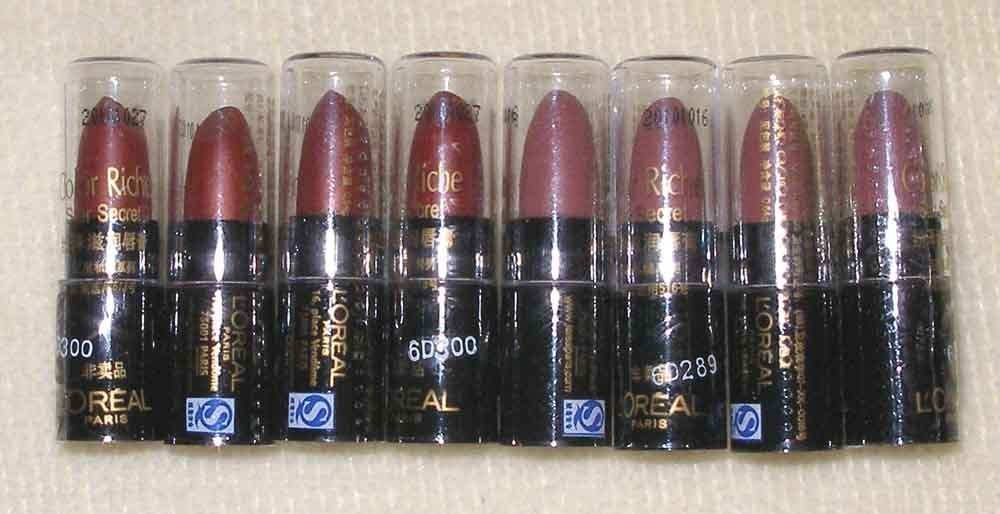

Image ILSVRC2012_val_00048584.JPEG: lipstick, lip rouge (synset ID: `n03676483`)

In [43]:
rand_synset_id = random.choice(os.listdir('../data/imagenet/images/train/'))
synset_id_dir = f'../data/imagenet/images/train/{rand_synset_id}'

with open(f'{synset_id_dir}/._SYNSET_.pickle', 'rb') as f:
    synset = pickle.load(f)
assert rand_synset_id == synset['synset_id']

for _ in range(3):
    img_path = random.choice([x for x in os.listdir(synset_id_dir) if not 'pickle' in x])
    
    display(Image(f'{synset_id_dir}/{img_path}'))
    display(Markdown(f"Image {img_path}: {synset['name']} (synset ID: `{synset['synset_id']}`)"))

# get "simple labels"

CLIP uses ["simple labels"](https://github.com/anishathalye/imagenet-simple-labels) for zero-shot image classification on ImageNet, but we have to set these up for ILSVRC2010 (i.e. we can't re-use [CoOp's](https://drive.google.com/file/d/1-61f_ol79pViBFDG_IDlUQSwoLcn2XXF/view?usp=sharing) bc, while the labels are the same, they occur in a different order)

In [44]:
!wget https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt
!mv imagenet1000_clsidx_to_labels.txt diff_imagenet_labelidx_to_names.json

--2022-04-23 19:07:37--  https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30564 (30K) [text/plain]
Saving to: ‘imagenet1000_clsidx_to_labels.txt’

imagenet1000_clsidx 100%[===================>]  29.85K  --.-KB/s    in 0s      

2022-04-23 19:07:37 (113 MB/s) - ‘imagenet1000_clsidx_to_labels.txt’ saved [30564/30564]



In [45]:
import ast

with open('diff_imagenet_labelidx_to_names.json', 'w') as f:
    diff_imagenet_labelidx_to_names = ast.literal_eval(f.read())

In [47]:
!rm diff_imagenet_labelidx_to_names.json

In [52]:
# make sure they have the same entries, even if they're in diff order

diff_imagenet_clsnames = diff_imagenet_labelidx_to_names.values()
imagenet_clsnames = synset_id_to_class_name.values()
for class_name in diff_imagenet_clsnames:
    assert class_name in imagenet_clsnames

Perfect! ILSVRC 2012 appears to have the correct classes, then. (ILSVRC 2010 failed this `assert`.)

However, the synset IDs do not match up, so we'll need to adapt CoOp's `classnames.txt` for our synset IDs.

In [61]:
!wget https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json
    
with open('imagenet-simple-labels.json', 'r') as f:
    simple_clsnames = ast.literal_eval(f.read())

!rm imagenet-simple-labels.json

--2022-04-25 16:39:34--  https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14193 (14K) [text/plain]
Saving to: ‘imagenet-simple-labels.json’

imagenet-simple-lab 100%[===================>]  13.86K  --.-KB/s    in 0s      

2022-04-25 16:39:34 (81.9 MB/s) - ‘imagenet-simple-labels.json’ saved [14193/14193]



In [70]:
og_clsnames_to_synset_ids = dict()
for synset in int_label_to_synset.values():
    og_clsnames_to_synset_ids[synset['name']] = synset['synset_id']

In [74]:
# diff_imagenet_names_to_labelidx = {val: key for key, val in diff_imagenet_labelidx_to_names.items()} # 1

with open('../data/imagenet/classnames.txt', 'w') as f:
    for label_idx, class_name in enumerate(simple_clsnames):
        og_clsname = diff_imagenet_labelidx_to_names[label_idx]
        synset_id = og_clsnames_to_synset_ids[og_clsname]

    #     print(og_clsname, class_name, synset_id)
    #     if label_idx > 5:
    #         break
        f.write(f'{synset_id} {class_name}\n')

... and it still doesn't work. I give up.

# create fake test data too

(beginning 2022.05.06)

(so now train, val, and test are all copies of val. definitely best practice)

In [6]:
import os
import sys

val_dir = '/shared/timan108/imagenet/images/val'
test_dir = '/shared/timan108/imagenet/images/test'

In [ ]:
# !cp -r /shared/timan108/imagenet/images/val /shared/timan108/imagenet/images/test

In [11]:
for filename in os.listdir(test_dir):
    test_filename = '_test_'.join(filename.split('_val_'))
    os.rename(f'{test_dir}/{filename}', f'{test_dir}/{test_filename}')